In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "/content/gdrive/MyDrive/deep_learning_project/"
!pip install import-ipynb

/content/gdrive/MyDrive/deep_learning_project


# IMAGE LOADING AND DATASET SAVING

importing Jupyter notebook from utils.ipynb


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


------------------------------------------------
original distribution


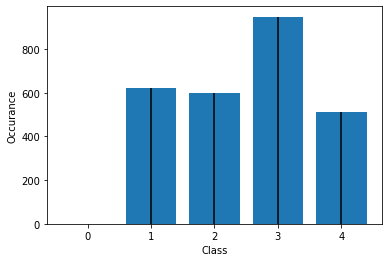

------------------------------------------------
testing set


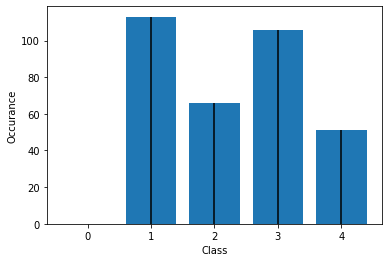

In [3]:
import import_ipynb
from utils import *
from PIL import Image, ImageEnhance
import tensorflow as tf

training_images, training_labels = load_training()
testing_images, testing_labels= load_testing()
labels_distribution(training_labels,"original distribution")
labels_distribution(testing_labels,"testing set")

------------------------------------------------
traducted training


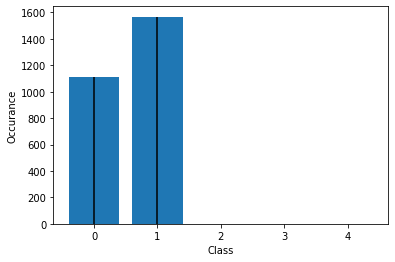

------------------------------------------------
traducted testing


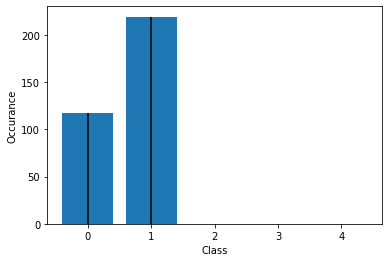

(2676, 150, 150)


In [4]:
training_labels = label_traduction(training_labels,0)
testing_labels = label_traduction(testing_labels,0)
labels_distribution(training_labels,"traducted training")
labels_distribution(testing_labels,"traducted testing")
print(np.shape(training_images))

Oversampling on label 0
------------------------------------------------
oversampled distribution


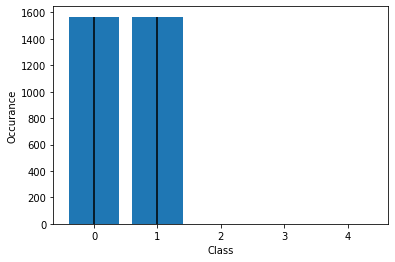

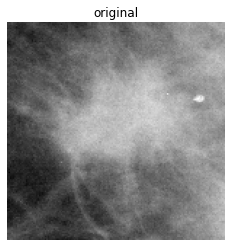

In [5]:
#training_images, training_labels = oversample(training_images,training_labels)
training_images, training_labels = gan_oversample(training_images,training_labels,0)
labels_distribution(training_labels,"oversampled distribution")
visualize_image(training_images[0],"original")

In [6]:
training_images,training_labels = shuffle_data(training_images,training_labels)
#labels_distribution(training_labels,"oversampled distribution shuffled")

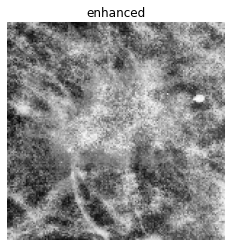

In [7]:

training_images = enhance_image(training_images)
testing_images = enhance_image(testing_images)
#training_images = enhance_contrast(training_images)
#testing_images = enhance_contrast(testing_images)
visualize_image(training_images[0],"enhanced")


In [8]:

training_images = filter_dataset(training_images)
testing_images = filter_dataset(testing_images)


# Dataset importing

In [9]:
import tensorflow as tf
TRAIN_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/train"
TEST_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/test"
BATCH_SIZE = 32
NORMALIZATION = 65536

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)
'''
train_datagen = ImageDataGenerator(
    rescale=1./NORMALIZATION,
    #rotation_range=40,
    rotation_range=90,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=20,
    #zoom_range=0.2,
    #horizontal_flip=True,
    )
'''

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)

#training_images =  np.array(training_images)
#testing_images =  np.array(testing_images)

training_images = np.expand_dims(training_images, -1)
testing_images = np.expand_dims(testing_images, -1)

splitted_train_images, splitted_val_images, splitted_train_labels, splitted_val_labels = train_test_split(training_images, training_labels, test_size=0.2, stratify=training_labels)


train_generator = train_datagen.flow(splitted_train_images, 
                                     y=splitted_train_labels, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)

validation_generator = train_datagen.flow(splitted_val_images, 
                                          y=splitted_val_labels, 
                                          batch_size=BATCH_SIZE, 
                                          seed=123)

test_generator =  test_datagen.flow(testing_images,
                                    y=testing_labels,
                                    batch_size=BATCH_SIZE,
                                    seed=123)

# CNN Model Construction

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

#model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                        input_shape=(150, 150, 3)))

model.add(tf.keras.Input(shape=(150,150,1)))
model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123))
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add( layers.MaxPooling2D((2, 2)) )

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 150, 150, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

# Model Compile

In [12]:
import tensorflow as tf
from tensorflow.keras import optimizers


model.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=0.001),
              #optimizer='adam',
              metrics=['accuracy'])



# Model Fitting

In [13]:
EPOCHS = 35

history = model.fit(
    train_generator, 
    epochs = EPOCHS,
    validation_data = validation_generator,
    )

Epoch 1/35
79/79 [==============================] - 7s 46ms/step - loss: 1.0661 - accuracy: 0.5658 - val_loss: 1.4014 - val_accuracy: 0.5000
Epoch 2/35
79/79 [==============================] - 3s 36ms/step - loss: 0.6529 - accuracy: 0.5957 - val_loss: 0.7494 - val_accuracy: 0.5080
Epoch 3/35
79/79 [==============================] - 3s 36ms/step - loss: 0.6216 - accuracy: 0.6057 - val_loss: 1.2380 - val_accuracy: 0.5828
Epoch 4/35
79/79 [==============================] - 3s 36ms/step - loss: 0.6367 - accuracy: 0.6208 - val_loss: 0.6186 - val_accuracy: 0.6194
Epoch 5/35
79/79 [==============================] - 3s 36ms/step - loss: 0.6160 - accuracy: 0.6308 - val_loss: 0.6408 - val_accuracy: 0.5955
Epoch 6/35
79/79 [==============================] - 3s 36ms/step - loss: 0.5988 - accuracy: 0.6288 - val_loss: 0.5677 - val_accuracy: 0.6688
Epoch 7/35
79/79 [==============================] - 3s 36ms/step - loss: 0.5793 - accuracy: 0.6487 - val_loss: 0.5834 - val_accuracy: 0.6736
Epoch 8/35
79

#Model Saving

In [18]:

import pickle

path = "/content/gdrive/MyDrive/deep_learning_project/models/2.2/"
model_name = "Scratch_CNN"

model.save( path + model_name + ".h5")

with open(path + model_name + "_history.pickle", 'wb') as file_pi:
        pickle.dump(history.history,  file_pi)


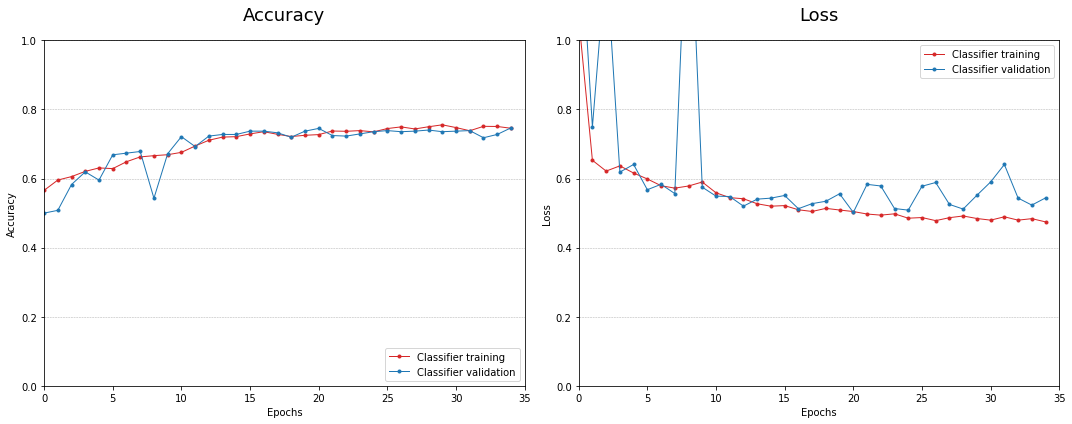

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:red', marker='.', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)
acc_g.axis([0,35,0,1])

# plot loss curves
loss_g.plot(epochs, loss, color='tab:red', marker='.', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)
loss_g.axis([0,35,0,1])


# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

11/11 [==============================] - 0s 28ms/step - loss: 0.6197 - accuracy: 0.7113
Test loss 0.619688093662262
Test accuracy 0.711309552192688


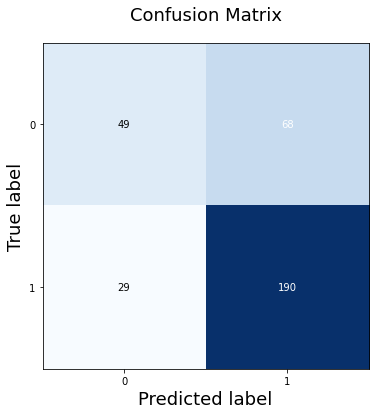

precision score:  0.7364341085271318
recall score:  0.867579908675799
f2:  0.837742504409171
f0.5:  0.759392486011191
classification report: 
               precision    recall  f1-score   support

           0       0.63      0.42      0.50       117
           1       0.74      0.87      0.80       219

    accuracy                           0.71       336
   macro avg       0.68      0.64      0.65       336
weighted avg       0.70      0.71      0.69       336

AUC:  0.6431916637396089


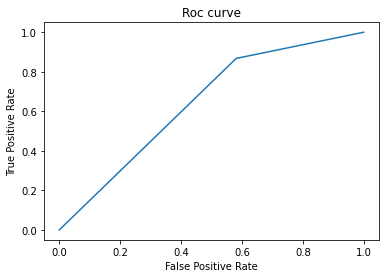

In [17]:
prediction = model.predict(testing_images/65536)
in_depth_performance(testing_labels,np.where(prediction > 0.5, 1,0)) #np.where is used to conver from probability to binary label